In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters

In [4]:
torch.manual_seed(1)

In [5]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [6]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [25]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [36]:
#train function
def trainFunc(model,num_epochs,train_batch_size):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    not_converged =True
    epoch = 0
    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            
            # Forward pass
            prediction = model(images.view(-1,784))
            loss = loss_func(prediction, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            if (i+1) % 10 == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                # train_epoch.append(epoch)
                # print(f'Epoch [{epoch}/{num_epochs}], Accuracy : {acc} %')
                # train_acc.append(acc)
                if epoch == num_epochs:
                        print("Max Epoch Reached")
                        not_converged = False
                elif (epoch > 5) and  (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergeance reached for loss:",train_losses[-1])
                        not_converged = False
                        
    return train_epoch,train_losses,train_acc

In [37]:
import copy

In [38]:
batchArr = np.linspace (10,1510,5)
print(batchArr)

[  10.  385.  760. 1135. 1510.]


In [58]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_load:
            prediction = model(images.view(-1,784))
            testLoss = loss_func(prediction,labels)
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1} %')
    return netTest_acc1, testLoss

In [66]:
#Calculation for sensitivity
def sensitivityFunc(model):
    gradArr = []
    froGrad=0
    count =0 
    sensitivity=[]
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            froGrad_norm = torch.norm(grad, p='fro')
            froGrad += froGrad_norm
            count += 1
        grad_all += grad
    grad_norm = grad_all ** 0.5
    gradArr.append(grad_norm)
    sensitivity.append(froGrad/count)
    return gradArr,sensitivity
        
    

In [65]:
modelsTrainEpochArr = []
modelsTrainLossArr = []
modelsTrainAccArr = []
modelsTestLossArr = []
modelsTestAccArr = []
modelsSensitivityArr=[]

for i in range (len(batchArr)):
    j=copy.deepcopy(i) 
    j = Model()
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(j.parameters(), lr=1e-3) #weight_decay = weight_decay_val)

    max_epochs = 15
    train_batch_size = int(batchArr[i])

    a=[]
    for k in j.parameters():
        a.append(torch.numel(k))
    print(f'Total no of parameters in Model :{np.sum(a)} for with batch size:{train_batch_size}')

    train_epoch,train_losses,train_acc = trainFunc(j,max_epochs,train_batch_size)

    test_batch_size = int(batchArr[i])

    testLoss, testAcc = testFunction(j,loss_func,test_batch_size)

    gradArr,sensitivity = sensitivityFunc(j)
    
    modelsTrainEpochArr.append(train_epoch)
    modelsTrainLossArr.append(train_losses)
    modelsTrainAccArr.append(train_acc)
    modelsTestAccArr.append(testAcc)
    modelsTestLossArr.append(testLoss)
    modelsSensitivityArr.append(sensitivity)

Total no of parameters in Model :84060 for with batch size:10
strated
Train O/P: Epoch [1/15], Step [10/6000], Loss: 2.3100
Train O/P: Epoch [1/15], Step [20/6000], Loss: 2.2461
Train O/P: Epoch [1/15], Step [30/6000], Loss: 2.0772
Train O/P: Epoch [1/15], Step [40/6000], Loss: 1.8255
Train O/P: Epoch [1/15], Step [50/6000], Loss: 1.5338
Train O/P: Epoch [1/15], Step [60/6000], Loss: 1.6724
Train O/P: Epoch [1/15], Step [70/6000], Loss: 1.2940
Train O/P: Epoch [1/15], Step [80/6000], Loss: 1.2695
Train O/P: Epoch [1/15], Step [90/6000], Loss: 1.0237
Train O/P: Epoch [1/15], Step [100/6000], Loss: 0.5741
Train O/P: Epoch [1/15], Step [110/6000], Loss: 0.7218
Train O/P: Epoch [1/15], Step [120/6000], Loss: 1.1984
Train O/P: Epoch [1/15], Step [130/6000], Loss: 0.6655
Train O/P: Epoch [1/15], Step [140/6000], Loss: 0.3398
Train O/P: Epoch [1/15], Step [150/6000], Loss: 0.9652
Train O/P: Epoch [1/15], Step [160/6000], Loss: 0.6454
Train O/P: Epoch [1/15], Step [170/6000], Loss: 0.6610
Trai

KeyboardInterrupt: 

In [57]:
len(modelsTrainAccArr)

5

In [60]:
# modelsTestLossArr = []
# modelsTestAccArr = []

# for i in range (len(batchArr)):
#     j=copy.deepcopy(i) 
#     j = Model()
#     loss_func = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(j.parameters(), lr=1e-3) #weight_decay = weight_decay_val)

#     test_batch_size = int(batchArr[i])

#     testLoss, testAcc = testFunction(j,loss_func,test_batch_size)
#     modelsTestAccArr.append(testAcc)

Accuracy of the network on the test images: 7.31 %
Accuracy of the network on the test images: 10.46 %
Accuracy of the network on the test images: 10.65 %
Accuracy of the network on the test images: 11.31 %
Accuracy of the network on the test images: 8.99 %


In [ ]:
modelsSensitivityArr

NameError: name 'alpha' is not defined

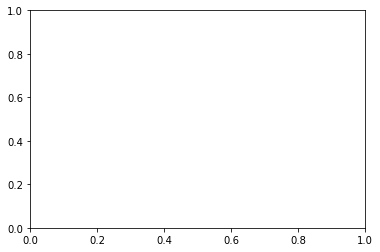

In [42]:
fig,ax=plt.subplots()
ax.plot(batchArr,minScore(modelsTrainLossArr),color="Blue",linestyle='dashed', marker="o")
ax.plot(batchArr,modelsTestLossArr,color="Blue", marker="v")
ax.legend(['Train Loss','Test Loss'],loc="upper right")
ax.set_xlabel("Batch",color="Green")
ax.set_ylabel("CrossEntropy Loss",color = "blue")


ax2=ax.twinx()
ax2.plot(batchArr,modelsSensitivityArr,color="red")
ax2.set_xlabel("Batch",color="Green")
ax2.set_ylabel("Sensitivity",color = "red")
ax2.legend(['Sensitivity'],loc="center left")

plt.show()
fig.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/Diff Batch Graph HW1_3.2.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')